In [84]:
import torch
import torch.nn as nn
from torchvision import models, datasets
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from recycling_app.preprocessing.Preprocessing import Preprocessor
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from torch import optim

# Getting ready for modelling

In [25]:
# bc i hope we will finish this project befor the end of January 2025 xd
random_seed = 125

In [26]:
prepocessor = Preprocessor()

In [27]:
dataset_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw")
dataset = datasets.ImageFolder(dataset_path, transform=prepocessor.transform)

In [28]:
print(f"Labels: {dataset.classes}")

Labels: ['cardboard', 'food_organics', 'glass', 'metal', 'paper', 'plastic', 'textile', 'trash', 'vegetation']


In [29]:
test_size = int(0.2 * len(dataset))
train_val_size = len(dataset) - test_size
train_size = int(0.8 * train_val_size)
val_size = train_val_size - train_size

In [30]:
train_val_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [train_val_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

In [31]:
train_dataset, val_dataset = torch.utils.data.random_split(
    train_val_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(random_seed)
)

In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

# ResNet50

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])
resnet50.to(device)
resnet50.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [65]:
def extract_features(data_loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Extracting features", unit="batch"):
            inputs = inputs.to(device)
            output = model(inputs).squeeze()
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

In [66]:
train_features, train_labels = extract_features(train_loader, resnet50, device)

Extracting features: 100%|██████████| 292/292 [06:27<00:00,  1.33s/batch]


In [67]:
val_features, val_labels = extract_features(val_loader, resnet50, device)

Extracting features: 100%|██████████| 73/73 [01:34<00:00,  1.29s/batch]


In [106]:
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)

train_features = torch.tensor(train_features, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

C:\Users\alicj\AppData\Local\Temp\ipykernel_11784\1432164870.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32)
C:\Users\alicj\AppData\Local\Temp\ipykernel_11784\1432164870.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_features = torch.tensor(val_features, dtype=torch.float32)
C:\Users\alicj\AppData\Local\Temp\ipykernel_11784\1432164870.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.long)
C:\Users\alicj\

In [107]:
len(train_features[0])

2048

# SVM Classification

In [123]:
class SVC_Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SVC_Model, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)


In [129]:
model = SVC_Model(2048, 9)
criterion = nn.MultiMarginLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [133]:
num_epochs = 10000
iterations = tqdm(range(num_epochs))
for epoch in iterations:
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad()
    outputs = model(train_features)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    iterations.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10000/10000], Loss: 0.0159: 100%|██████████| 10000/10000 [02:24<00:00, 69.28it/s]


In [134]:
logits = model(val_features)
probabilities = torch.softmax(logits, dim=1)
predictions = torch.argmax(probabilities, dim=1)
accuracy = accuracy_score(val_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 73.05%


In [135]:
cm = confusion_matrix(val_labels, predictions)

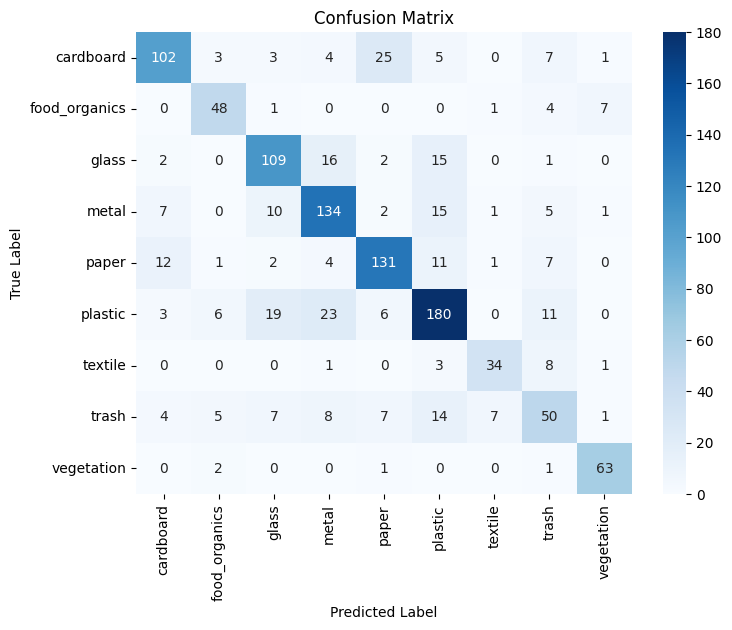

In [136]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()